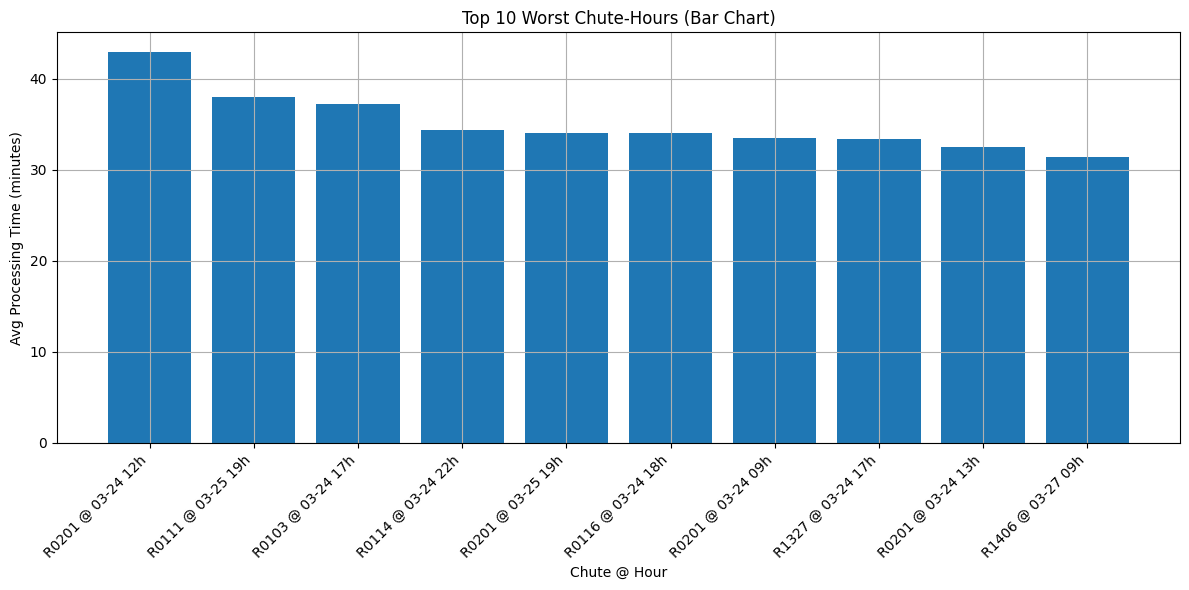

In [14]:
import oracledb
import pandas as pd
import matplotlib.pyplot as plt

# Oracle connection
user = 'test'
password = 'test'
dsn = 'he11-scan.pnet.ch:1521/P55PDS_REPORT.WORLD'

# SQL query
sql = """
SELECT *
FROM (
    SELECT
        TO_CHAR(CODS_COD_DAT, 'YYYY-MM-DD HH24') AS hour_time,
        CODS_ZENT_NR,
        CODS_SD_RUTSCHE AS chute,
        COUNT(*) AS package_count,
        COUNT(*) OVER (PARTITION BY CODS_SD_RUTSCHE, TO_CHAR(CODS_COD_DAT, 'YYYY-MM-DD HH24')) AS chute_load,
        AVG((CODS_LERE_DAT - CODS_COD_DAT) * 24 * 60) AS avg_processing_time_minutes,
        1 AS performance_issue
    FROM
        pds_cod_sdr
    WHERE
        CODS_COD_DAT > SYSDATE - 4
        AND CODS_ZENT_NR IN (2, 3)
        AND CODS_SD_RUTSCHE IS NOT NULL
        AND CODS_LERE_DAT IS NOT NULL
    GROUP BY
        TO_CHAR(CODS_COD_DAT, 'YYYY-MM-DD HH24'),
        CODS_ZENT_NR,
        CODS_SD_RUTSCHE
    HAVING
        COUNT(*) > 10
        AND AVG((CODS_LERE_DAT - CODS_COD_DAT) * 24 * 60) > 10
    ORDER BY
        avg_processing_time_minutes DESC
)
WHERE ROWNUM <= 10
"""

# Query Oracle and fetch results
with oracledb.connect(user=user, password=password, dsn=dsn) as connection:
    with connection.cursor() as cursor:
        cursor.execute(sql)
        columns = [col[0] for col in cursor.description]
        rows = cursor.fetchall()
        df = pd.DataFrame(rows, columns=columns)

# Convert hour_time to datetime
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'], format='%Y-%m-%d %H')

# Create a label that combines chute + hour for unique bars
df['LABEL'] = df['CHUTE'].astype(str) + ' @ ' + df['HOUR_TIME'].dt.strftime('%m-%d %Hh')

# Plotting: bar chart
plt.figure(figsize=(12, 6))
plt.bar(df['LABEL'], df['AVG_PROCESSING_TIME_MINUTES'])

plt.xlabel('Chute @ Hour')
plt.ylabel('Avg Processing Time (minutes)')
plt.title('Top 10 Worst Chute-Hours (Bar Chart)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


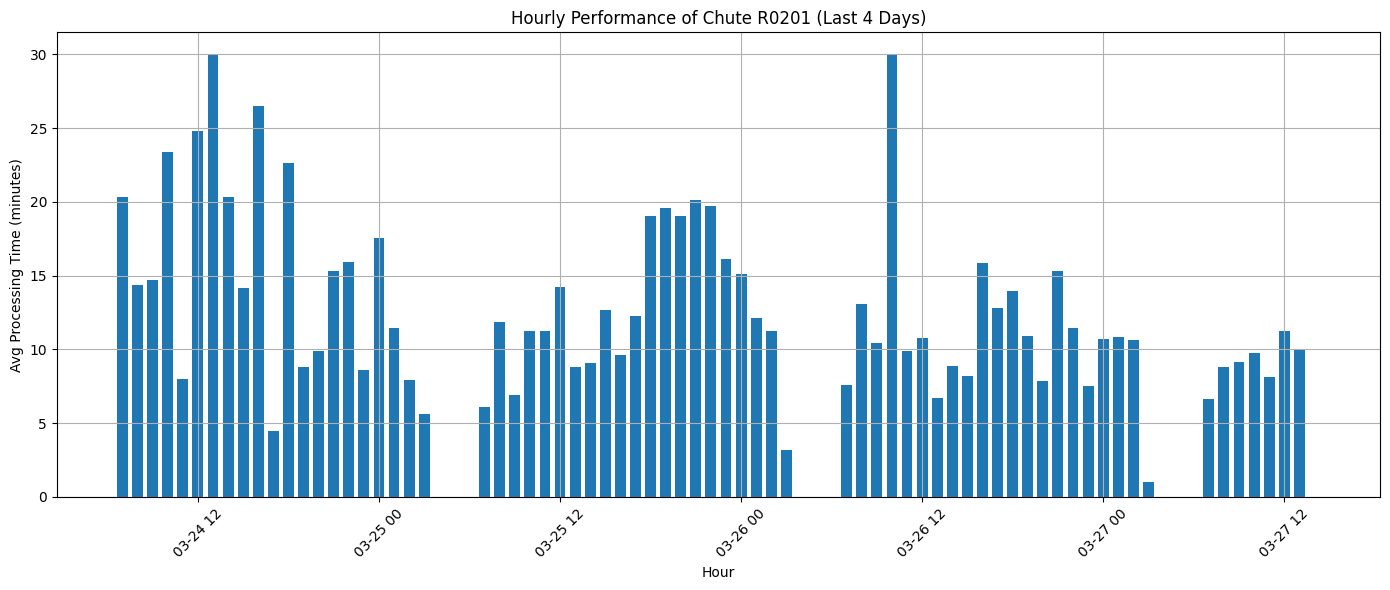

In [15]:
import oracledb
import pandas as pd
import matplotlib.pyplot as plt

# Oracle connection
user = 'test'
password = 'test'
dsn = 'he11-scan.pnet.ch:1521/P55PDS_REPORT.WORLD'

# SQL for R0201 hourly performance
sql = """
SELECT
    TO_CHAR(CODS_COD_DAT, 'YYYY-MM-DD HH24') AS hour_time,
    AVG((CODS_LERE_DAT - CODS_COD_DAT) * 24 * 60) AS avg_processing_time_minutes
FROM
    pds_cod_sdr
WHERE
    CODS_COD_DAT > SYSDATE - 4
    AND CODS_ZENT_NR IN (2, 3)
    AND CODS_SD_RUTSCHE = 'R0201'
    AND CODS_LERE_DAT IS NOT NULL
GROUP BY
    TO_CHAR(CODS_COD_DAT, 'YYYY-MM-DD HH24')
ORDER BY
    hour_time
"""

# Query data
with oracledb.connect(user=user, password=password, dsn=dsn) as connection:
    with connection.cursor() as cursor:
        cursor.execute(sql)
        columns = [col[0] for col in cursor.description]
        rows = cursor.fetchall()
        df = pd.DataFrame(rows, columns=columns)

# Convert hour_time to datetime
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'], format='%Y-%m-%d %H')

# Plot
plt.figure(figsize=(14, 6))
plt.bar(df['HOUR_TIME'], df['AVG_PROCESSING_TIME_MINUTES'], width=0.03)

plt.xlabel('Hour')
plt.ylabel('Avg Processing Time (minutes)')
plt.title('Hourly Performance of Chute R0201 (Last 4 Days)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


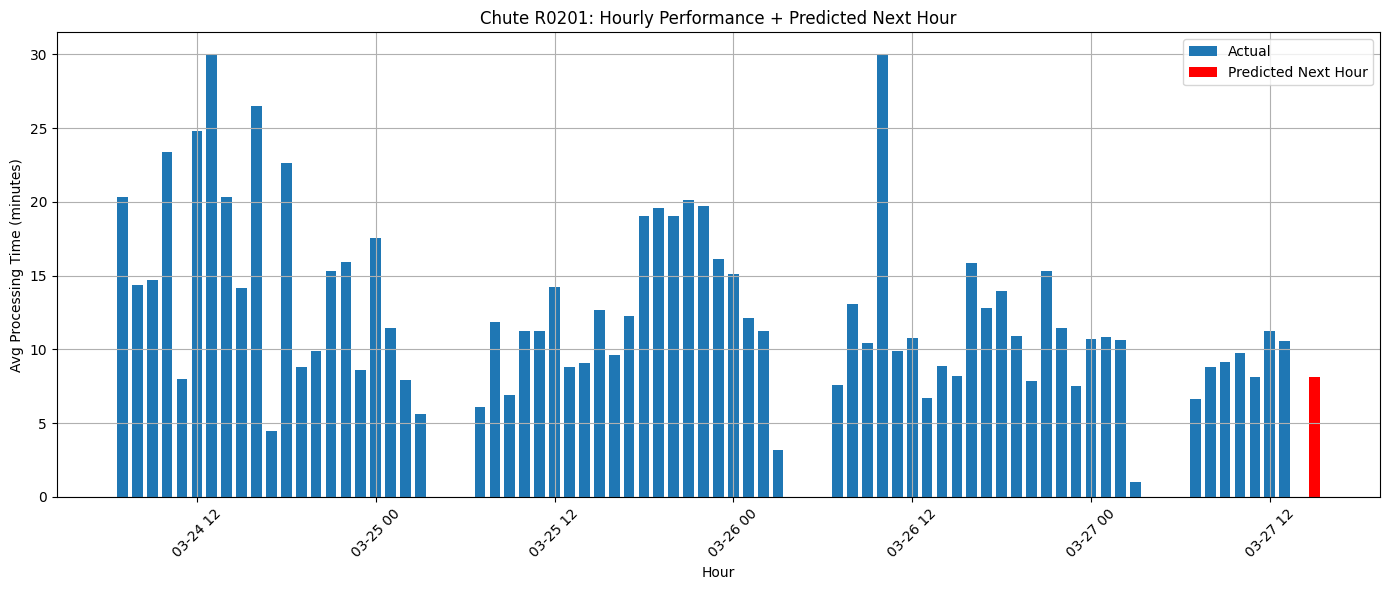

In [16]:
import oracledb
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# Oracle connection
user = 'test'
password = 'test'
dsn = 'he11-scan.pnet.ch:1521/P55PDS_REPORT.WORLD'

# SQL: historical hourly performance for R0201
sql = """
SELECT
    TO_CHAR(CODS_COD_DAT, 'YYYY-MM-DD HH24') AS hour_time,
    AVG((CODS_LERE_DAT - CODS_COD_DAT) * 24 * 60) AS avg_processing_time_minutes
FROM
    pds_cod_sdr
WHERE
    CODS_COD_DAT > SYSDATE - 4
    AND CODS_ZENT_NR IN (2, 3)
    AND CODS_SD_RUTSCHE = 'R0201'
    AND CODS_LERE_DAT IS NOT NULL
GROUP BY
    TO_CHAR(CODS_COD_DAT, 'YYYY-MM-DD HH24')
ORDER BY
    hour_time
"""

# Query Oracle
with oracledb.connect(user=user, password=password, dsn=dsn) as connection:
    with connection.cursor() as cursor:
        cursor.execute(sql)
        columns = [col[0] for col in cursor.description]
        rows = cursor.fetchall()
        df = pd.DataFrame(rows, columns=columns)

# Convert hour_time to datetime
df['HOUR_TIME'] = pd.to_datetime(df['HOUR_TIME'], format='%Y-%m-%d %H')
df['AVG_PROCESSING_TIME_MINUTES'] = df['AVG_PROCESSING_TIME_MINUTES'].astype(float)

# Predict the next hour
next_hour = df['HOUR_TIME'].max() + timedelta(hours=1)
predicted_value = df['AVG_PROCESSING_TIME_MINUTES'].tail(6).mean()  # or use model later

# Append predicted row
predicted_df = pd.DataFrame({
    'HOUR_TIME': [next_hour],
    'AVG_PROCESSING_TIME_MINUTES': [predicted_value]
})
df_full = pd.concat([df, predicted_df], ignore_index=True)

# Plot
plt.figure(figsize=(14, 6))

# Historical bars
plt.bar(df['HOUR_TIME'], df['AVG_PROCESSING_TIME_MINUTES'], width=0.03, label='Actual')

# Predicted bar (highlighted)
plt.bar(predicted_df['HOUR_TIME'], predicted_df['AVG_PROCESSING_TIME_MINUTES'],
        color='red', width=0.03, label='Predicted Next Hour')

plt.xlabel('Hour')
plt.ylabel('Avg Processing Time (minutes)')
plt.title('Chute R0201: Hourly Performance + Predicted Next Hour')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
